In [ ]:
import numpy as np
from sklearn.decomposition import PCA, FastICA, NMF
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
_LOAD_UNZIP = False
_LIMITS = True
_SHUFFLE = True
_SEED = 0

In [ ]:
# Helpers

def get_labels_df(labels_path, names_path=None):
    '''
    Return a pandas data frame with the following columns:
        Index (automatically generated). Can be useful if we need to reset it later.
        Processed_image filename as in the Faces folder, without the .jpg filetype extension
        Image actual file name, if names_path is not None or empty.
        Age: int, positive
        Gender: binary ,0: male, 1: female
        Race: int. 0:white, 1:black, 2:asian, 3:indian, 4:other
    '''
    import pandas as pd
    labels_columns = ['age', 'gender', 'race']
    labels = pd.read_csv(labels_path, header=None)
    labels = pd.DataFrame(data=labels.values, columns=labels_columns)
    labels['image_no'] = labels.index
    if names_path is not None and names_path != '':
        names = []
        with open(names_path, 'r') as f:
            lines = f.readlines()
            names = [i.strip() for i in lines]
        labels['actual_filename'] = names
    cols = labels.columns.to_list()
    cols = cols[-1:] + cols[-2:-1] + cols[:3]
    labels = labels[cols]
    return labels

In [ ]:
# Helpers
def get_dimensions_from_an_image(faces_path, image_no=0, as_gray=True):
    '''
    Returns 2 integers, height (h) and width (w) as dimensions of an image
    '''
    from skimage import io
    test_img = io.imread(faces_path+f"{image_no}.jpg", as_gray=as_gray)
    if as_gray:
        h, w = test_img.shape
        return h, w
    h, w, _ = test_img.shape
    return h, w

In [ ]:
def pick_n_from_label(df, n, label, random_state=0, shuffle=True):
    '''
    Returns list of image names to load.
    n: int, Number of elements from each label
    label: string, Column from the pandas object to pick from its elements
    If label == 'random', then n random images are loaded
    '''
    labels = df.copy()
    lbl = label.lower()
    image_names_to_load = []
    if lbl == 'random':
        indices = labels.index.to_list()
        if shuffle:
            np.random.seed(random_state)
            np.random.shuffle(indices)
        try:
            image_names_to_load += indices[:n]
        except IndexError:
            image_names_to_load += indices
        return image_names_to_load
    for i in labels[lbl].unique():
        indices = labels[labels[lbl] == i].index.to_list()
        if shuffle:
            np.random.seed(random_state)
            np.random.shuffle(indices)
        try:
            image_names_to_load += indices[:n]
        except IndexError:
            image_names_to_load += indices
    return image_names_to_load

In [ ]:
# Import images
if _LOAD_UNZIP:
    from google.colab import drive
    drive.mount('/content/gdrive')
    !unzip gdrive/My\ Drive/data.zip > /dev/null

In [ ]:
# Set the paths for image files, labels etc
faces_path = "data/Faces/"
labels_path = "data/labels.csv"
names_path = "data/filenames.txt"

In [ ]:
# Get labels
labels = get_labels_df(labels_path=labels_path, names_path=names_path)

In [ ]:
if _LIMITS:
    age_min = 18
    age_max = 40
    labels = labels.loc[(labels.age >= age_min) & (labels.age <= age_max)]

In [ ]:
# Put age in bins
age_bin_width_years = 25
ages = labels.age.values//age_bin_width_years  # bin_width fully lived
labels.drop(['age'], axis=1, inplace=True)
labels['age_bin'] = ages

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
h, w = get_dimensions_from_an_image(faces_path, 0, as_gray=True)

In [ ]:
from skimage import io, img_as_ubyte
from tqdm import tqdm

n_elements_from_label = 3500
label_to_choose_from = "gender"
images_to_load = pick_n_from_label(labels, n_elements_from_label, label_to_choose_from, shuffle=_SHUFFLE
)

X = np.empty((len(images_to_load), h * w), dtype=np.ubyte)

for i in tqdm(range(len(images_to_load))):
    a = io.imread(faces_path + f"{images_to_load[i]}.jpg", as_gray=True)
    a = img_as_ubyte(a)
    X[i, :] = a.reshape(1, -1)
del a
labels_loaded = labels.loc[images_to_load]
labels_loaded = labels_loaded.reset_index()

100%|██████████| 7000/7000 [00:21<00:00, 321.87it/s]


In [ ]:
from sklearn.model_selection import train_test_split

train_dataset_idx, test_dataset_idx = train_test_split(labels_loaded.index.to_list())

data_train, data_test = X[train_dataset_idx], X[test_dataset_idx]
labels_train, labels_test = labels_loaded.loc[train_dataset_idx], labels_loaded.loc[test_dataset_idx]
labels_train = labels_train.reset_index()
labels_test = labels_test.reset_index()
del X, labels  # to avoid accessing the test set and also to save ram


y_gender = labels_train.gender.values

In [ ]:
# X_train, X_val = train_test_split(data_train, random_state=_SEED, shuffle=True, test_size=0.15)

In [ ]:
import sklearn.preprocessing as preproc
from sklearn.decomposition import PCA, FastICA, NMF

scaler = preproc.StandardScaler()
X_train_sc, X_val_sc = scaler.fit_transform(data_train), scaler.transform(data_test)


In [ ]:
pca = PCA(n_components=0.985, random_state=_SEED).fit(X_train_sc)

In [ ]:
ica = FastICA(n_components=100, random_state=_SEED).fit(X_train_sc)

In [ ]:
nmf = NMF(n_components=100, random_state=_SEED).fit(data_train)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [ ]:
male_labels = labels_train.loc[labels_train.gender==0]
# male_labels = male_labels.reset_index()

female_labels = labels_train.loc[labels_train.gender==1]
# female_labels = female_labels.reset_index()

X_transf_pca = pca.transform(data_train)
X_transf_ica = ica.transform(data_train)
X_transf_nmf = nmf.transform(data_train)




In [ ]:
male_scores_pca = X_transf_pca[male_labels.index.to_list(),:].mean(0)
female_scores_pca = X_transf_pca[female_labels.index.to_list(),:].mean(0)

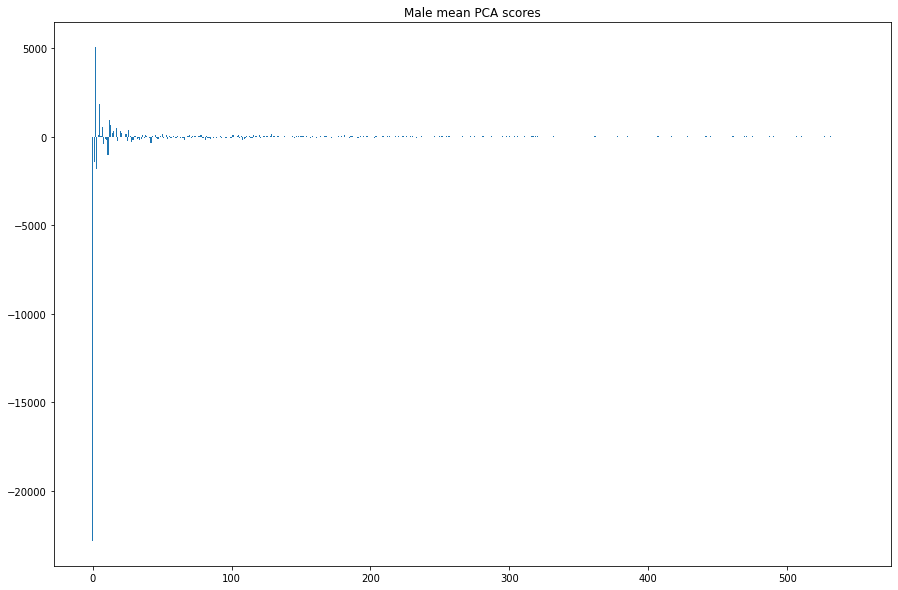

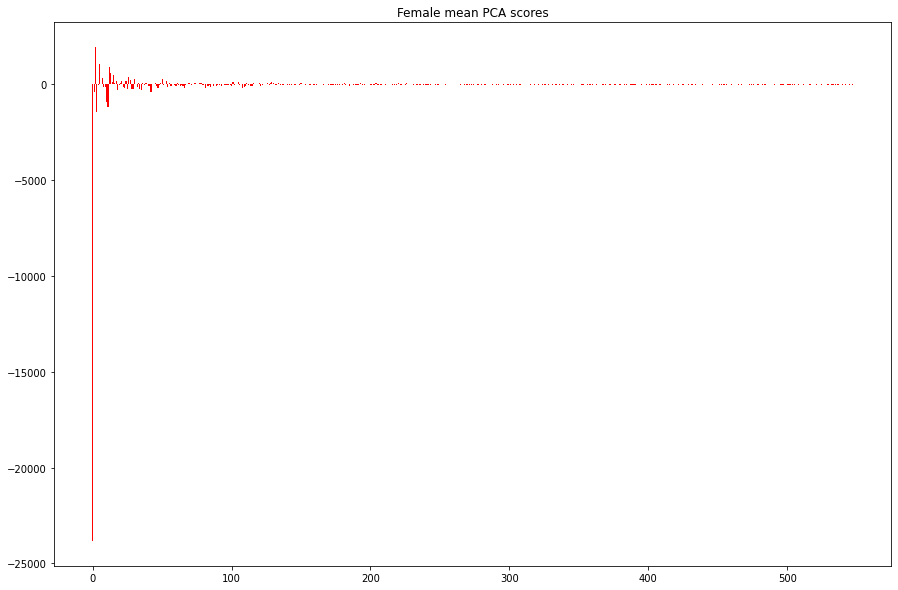

In [ ]:
plt.figure(figsize=(15,10))
plt.bar(list(range(pca.components_.shape[0])),male_scores_pca)
plt.title('Male mean PCA scores')
plt.show()

plt.figure(figsize=(15,10))
plt.bar(list(range(pca.components_.shape[0])),female_scores_pca,color='red')
plt.title('Female mean PCA scores')
plt.show()

In [ ]:
test_male_to_female = 6
test_female_to_male = 6

X_male_before = data_train[male_labels.index.to_list()[test_male_to_female-1]]
X_female_before = data_train[female_labels.index.to_list()[test_female_to_male-1]]

In [ ]:
female_to_male_scores_pca = male_scores_pca/female_scores_pca
male_to_female_scores_pca = female_scores_pca/male_scores_pca

X_female_recr_pca = pca.inverse_transform(pca.transform(X_male_before.reshape(1,-1))*male_to_female_scores_pca)
X_male_recr_pca = pca.inverse_transform(pca.transform(X_female_before.reshape(1,-1))*female_to_male_scores_pca)

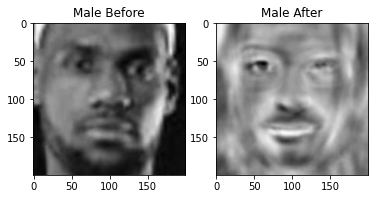

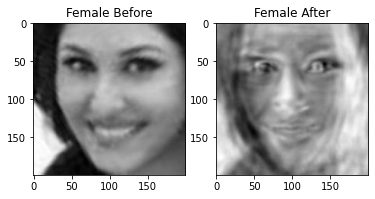

In [ ]:
plt.subplot(1,2,1)
plt.imshow(X_male_before.reshape(h,w), cmap='gray')
plt.title('Male Before')

plt.subplot(1,2,2)
plt.imshow((X_female_recr_pca).reshape(h,w), cmap='gray')
plt.title('Male After')
plt.show()

plt.subplot(1,2,1)
plt.imshow(X_female_before.reshape(h,w), cmap='gray')
plt.title('Female Before')

plt.subplot(1,2,2)
plt.imshow((X_male_recr_pca).reshape(h,w), cmap='gray')
plt.title('Female After')
plt.show()

In [ ]:
male_scores_ica = X_transf_ica[male_labels.index.to_list(),:].mean(0)
female_scores_ica = X_transf_ica[female_labels.index.to_list(),:].mean(0)

female_to_male_scores_ica = male_scores_ica/female_scores_ica
male_to_female_scores_ica = female_scores_ica/male_scores_ica

X_female_recr_ica = ica.inverse_transform(ica.transform(X_male_before.reshape(1,-1))*male_to_female_scores_ica) 
X_male_recr_ica = ica.inverse_transform(ica.transform(X_female_before.reshape(1,-1))*female_to_male_scores_ica) 

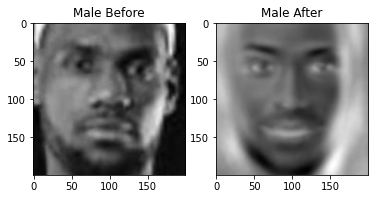

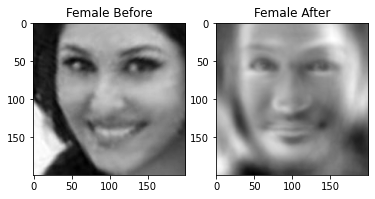

In [ ]:
plt.subplot(1,2,1)
plt.imshow(X_male_before.reshape(h,w), cmap='gray')
plt.title('Male Before')

plt.subplot(1,2,2)
plt.imshow(X_female_recr_ica.reshape(h,w), cmap='gray')
plt.title('Male After')
plt.show()

plt.subplot(1,2,1)
plt.imshow(X_female_before.reshape(h,w), cmap='gray')
plt.title('Female Before')

plt.subplot(1,2,2)
plt.imshow(X_male_recr_ica.reshape(h,w), cmap='gray')
plt.title('Female After')
plt.show()

In [ ]:
male_scores_nmf = X_transf_nmf[male_labels.index.to_list(),:].mean(0)
female_scores_nmf = X_transf_nmf[female_labels.index.to_list(),:].mean(0)

female_to_male_scores_nmf = male_scores_nmf/female_scores_nmf
male_to_female_scores_nmf = female_scores_nmf/male_scores_nmf

X_female_recr_nmf = nmf.inverse_transform(nmf.transform(X_male_before.reshape(1,-1))*male_to_female_scores_nmf)
X_male_recr_nmf = nmf.inverse_transform(nmf.transform(X_female_before.reshape(1,-1))*female_to_male_scores_nmf)

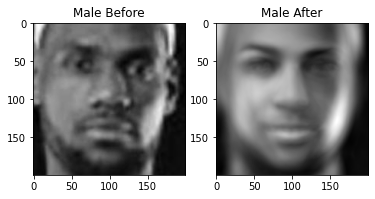

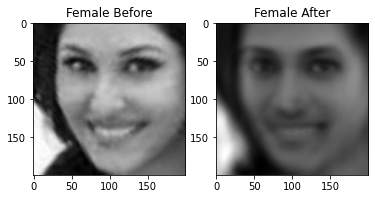

In [ ]:
plt.subplot(1,2,1)
plt.imshow(X_male_before.reshape(h,w), cmap='gray')
plt.title('Male Before')

plt.subplot(1,2,2)
plt.imshow(X_female_recr_nmf.reshape(h,w), cmap='gray')
plt.title('Male After')
plt.show()

plt.subplot(1,2,1)
plt.imshow(X_female_before.reshape(h,w), cmap='gray')
plt.title('Female Before')

plt.subplot(1,2,2)
plt.imshow(X_male_recr_nmf.reshape(h,w), cmap='gray')
plt.title('Female After')
plt.show()